In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://www.hs-coburg.de/wp-content/uploads/2024/11/CIDDS-001.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score,classification_report,confusion_matrix
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [3]:
df = pd.read_csv('CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv')

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---


In [5]:
# 미사용 컬럼 제거
df = df.drop(columns = ['Src Pt','Dst Pt','Flows','Tos','class','attackID','attackDescription'])
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,---


In [6]:
df['attackType'] = df['attackType'].replace('---','benign')
df['Date first seen'] = pd.to_datetime(df['Date first seen'])

In [7]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign


([<matplotlib.patches.Wedge at 0x35eabc490>,
 [Text(-0.9468730251355885, 0.5598495103780831, 'benign'),
  Text(0.9064854364573016, -0.6231245088189162, 'dos'),
  Text(1.0974386808803767, -0.07502227474249756, 'portScan')],
 [Text(-0.5164761955285028, 0.30537246020622705, '83%'),
  Text(0.49444660170398264, -0.3398860957194088, '15%'),
  Text(0.5986029168438418, -0.040921240768635035, '2%')])

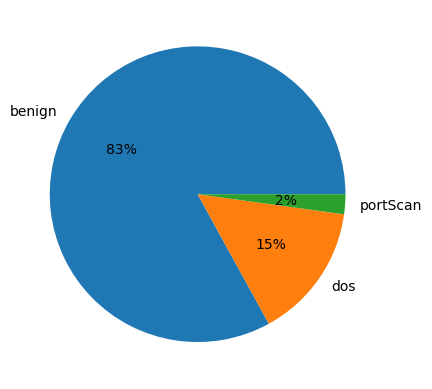

In [8]:
# 공격 타입 파이차트 시각화
count_labels = df['attackType'].value_counts() / len(df) * 100
top3_labels = df['attackType'].value_counts().index[:3]
plt.pie(count_labels[:3],labels=top3_labels,autopct='%.0f%%')

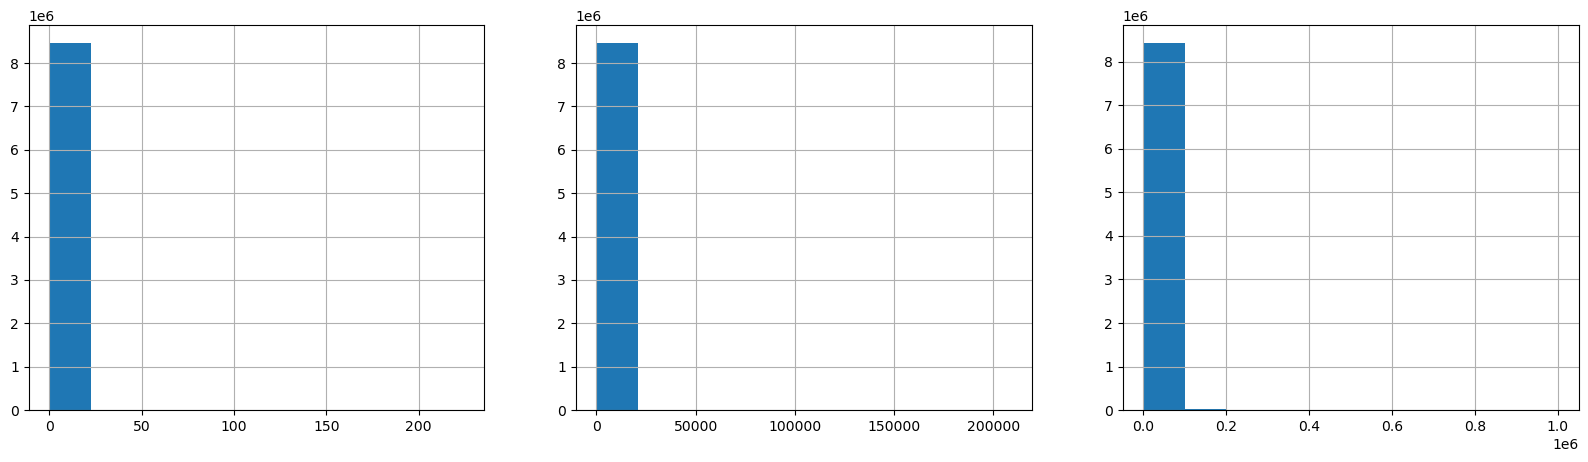

In [9]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(20,5))
df['Duration'].hist(ax=ax1)
ax1.set_label('Duration')
df['Packets'].hist(ax=ax2)
ax2.set_label('Packets')
pd.to_numeric(df['Bytes'],errors='coerce').hist(ax=ax3) # 변환불가시 NAN 처리
ax3.set_label('Bytes')
plt.show()

전처리

In [10]:
df['weekday'] = df['Date first seen'].dt.weekday
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday', # 각 요일에 맞게 원핫인코딩
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

In [11]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0


In [12]:
df['daytime'] = (df['Date first seen'].dt.second + df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60) / (24*60*60)
# 하루에 대한 초로 정규화( 0 ~ 1 )

In [13]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088


In [14]:
df['Flags'].value_counts()

.A....    2652182
......    1057702
.AP...    1049867
.AP.S.     848656
.AP.SF     834847
.A..SF     638075
.A...F     613708
.AP..F     254596
.A..S.     200000
....S.     114749
.A.R..      82399
...R..      46718
.APR.F      29520
.A.R.F       9743
.APR..       5810
.APRSF       4821
.APRS.       3850
...RS.       3174
.A.RS.        821
.A.RSF        282
Name: Flags, dtype: int64

In [15]:
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

In [16]:
df = df.reset_index(drop=True)
ohe_flags = df['Flags'].apply(one_hot_flags).to_list() # 데이터 프레임 모든 행에 각각 함수 적용
df[['ACK','PSH','RST','SYN','FIN']] = pd.DataFrame(ohe_flags,columns =['ACK','PSH','RST','SYN','FIN'])

In [17]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,...,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,...,0,0,0,0,0.00088,1,1,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0.00088,1,1,0,0,0
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0.00088,1,1,0,0,0
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0.00088,1,1,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0.00088,1,1,0,0,0


In [18]:
temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.',regex=True)] = '0.0.0.0' # IP 형식을 벗어나면 0
temp = temp['SrcIP'].str.split('.',expand=True).rename(columns = {2:'ipsrc3', 3:'ipsrc4'}).astype(int)[['ipsrc3','ipsrc4']]
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x,'b').zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x,'b').zfill(8))

In [19]:
df = df.join(temp['ipsrc'].str.split('',expand=True).drop(columns=[0,17]).rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)]))).astype('int32'))

In [20]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,...,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,0,1,1,1,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1


In [21]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) \
                + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,...,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,...,0,0,0,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,1,1,1,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,1,1,1,1


In [22]:
df['Bytes'].value_counts() # 16.8M 이라는 특성값 문제

      66    2256100
      54     359338
      55     293995
     108     263026
206          236488
             ...   
   44444          1
  16.8 M          1
  601310          1
  100236          1
   94675          1
Name: Bytes, Length: 94131, dtype: int64

In [23]:
m_index = df[pd.to_numeric(df['Bytes'],errors='coerce').isnull()==True].index # 넘파이 베열로 변환했을 때, 에러가 발생하는 위치
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
# 양쪽 공백제거 후 숫자만 백만을 곱

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
df['Bytes'] = pd.to_numeric(df['Bytes'],errors='coerce',downcast='integer') # 넘파이배열로 변환후 저장. 
# 가능한 작은 숫자 타입으로 변환

In [25]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,...,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,...,0,0,0,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,1,1,1,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,...,0,0,0,0,0,0,0,1,0,1
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,...,0,0,0,0,0,0,1,1,1,1


In [26]:
df = pd.get_dummies(df,prefix='',prefix_sep='',columns=['Proto','attackType'])

In [27]:
df.head(5)

,Date first seen,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,Monday,Tuesday,Wednesday,...,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
0,2017-03-15 00:01:16.632,0.000,192.168.100.5,192.168.220.16,1,108,.AP...,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,192.168.100.5,192.168.220.15,1,108,.AP...,0,0,1,...,1,0,0,1,0,1,0,0,0,0
2,2017-03-15 00:01:16.551,0.004,192.168.220.15,192.168.100.5,2,174,.AP...,0,0,1,...,1,0,0,1,0,1,0,0,0,0
3,2017-03-15 00:01:16.631,0.004,192.168.220.16,192.168.100.5,2,174,.AP...,0,0,1,...,1,0,0,1,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,192.168.100.5,192.168.220.15,1,108,.AP...,0,0,1,...,1,0,0,1,0,1,0,0,0,0


In [28]:
labels = ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']
df_train,df_test = train_test_split(df,random_state=0,test_size=0.2,stratify=df[labels])
df_val, df_test = train_test_split(df_test,random_state=0,test_size=0.5,stratify=df_test[labels])

In [29]:
### (중요) dataset을 split하고 scaling을 해야한다.
### 미리 해버리면 모델이 분포를 인지한 상태에서 학습을 해버림.
scaler = PowerTransformer()
df_train[['Duration','Packets','Bytes']] = scaler.fit_transform(df_train[['Duration','Packets','Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

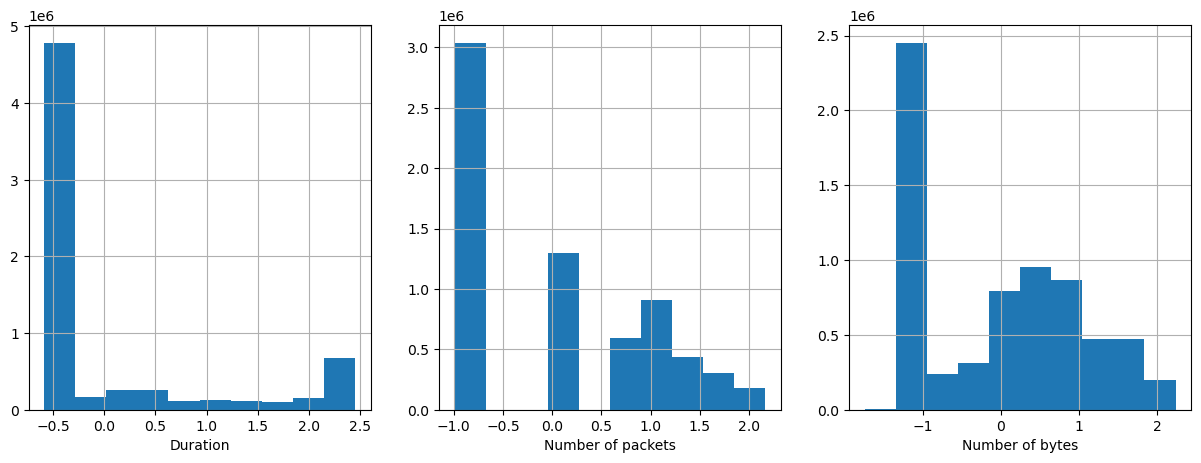

In [30]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df_train['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df_train['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
df_train['Bytes'].hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

In [31]:
# 정형 데이터를 그래프 데이터셋 형태로 변환해야 한다...

BATCH_SIZE = 16
features_host = [f'ipsrc_{i}' for i in range(1,17)] + [f'ipdst_{i}' for i in range(1,17)]
features_flow =  ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration'
,             'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

In [32]:
def get_connections(ip_map,src_ip,dst_ip):
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1,src2)).flatten() # 노드 정보

    dst = list(range(len(src_ip)))
    dst = np.column_stack((dst,dst)).flatten() # 흐름 정보

    return torch.Tensor([src,dst]).int(),torch.Tensor([dst,src]).int() #역으로도 지정을 해서 업데이트

In [33]:
# 데이터 로더 생성 함수 (용량이 커서 서브그래프로 분할)
def create_dataloader(df,subgraph_size=1024):
    data = []
    n_subgraph = len(df) // subgraph_size

    for i in range(1,n_subgraph+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size] # 1024개씩 구분
        src_ip = subgraph['Src IP Addr'].to_numpy()
        dst_ip = subgraph['Dst IP Addr'].to_numpy()

        ip_map = {ip:index for index,ip in enumerate(np.unique(np.append(src_ip,dst_ip)))} # 덧셈쓰면 안됨!!!!(넘파이 어레이는 확장이 아닌 덧셈임)

        host_to_flow, flow_to_host = get_connections(ip_map,src_ip,dst_ip)

        batch = HeteroData()
        batch['host'].x = torch.Tensor(subgraph[features_host].to_numpy()).float()
        batch['flow'].x = torch.Tensor(subgraph[features_flow].to_numpy()).float()
        batch['flow'].y = torch.Tensor(subgraph[labels].to_numpy()).float()
        batch['host','flow'].edge_index = host_to_flow
        batch['flow','host'].edge_index = flow_to_host
        data.append(batch)

    return DataLoader(data,batch_size=BATCH_SIZE)


In [34]:
train_loader = create_dataloader(df_train)
val_loader = create_dataloader(df_val)
test_loader = create_dataloader(df_test)

/var/folders/n9/654ym8ws0_j1lt2gmvbm6k2w0000gn/T/ipykernel_19495/2136885620.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.Tensor([src,dst]).int(),torch.Tensor([dst,src]).int() #역으로도 지정을 해서 업데이트


그래프 구현

In [35]:
import torch_geometric.transforms as T
from torch_geometric.nn import Linear,HeteroConv,SAGEConv

class HeteroGNN(torch.nn.Module):
    def __init__(self,dim_h,dim_out,num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers): 
            conv = HeteroConv({('host','to','flow') : SAGEConv((-1,-1),dim_h),
                               ('flow','to','host') : SAGEConv((-1,-1),dim_h,)},aggr='sum')
            self.convs.append(conv) # 레이어의 갯수만큼 모듈리스트에 추가
        self.lin = Linear(dim_h,dim_out)
    
    def forward(self,x_dict,edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict,edge_index_dict)
            x_dict = {key : F.leaky_relu(x) for key,x in x_dict.items()}
        return self.lin(x_dict['flow'])

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(dim_h=64, dim_out=5, num_layers=3).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [37]:
@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    n_subgraphs = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        out = model(batch.x_dict,batch.edge_index_dict)
        loss = F.cross_entropy(out,batch['flow'].y.float())

        y_pred.append(out.argmax(dim=1))
        y_true.append(batch['flow'].y.argmax(dim=1))

        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE

    y_pred = torch.cat(y_pred).cpu() # 레이블을 하나로 합침 (내부가 이중 텐서형태)
    y_true = torch.cat(y_true).cpu()
    f1score = f1_score(y_true,y_pred,average='macro')
    
    return total_loss/n_subgraphs, f1score,y_pred,y_true

In [38]:
model.train()
for epoch in range(101):
    n_subgraphs = 0
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        batch.to(device)
        out = model(batch.x_dict,batch.edge_index_dict)
        loss = F.cross_entropy(out,batch['flow'].y.float())
        loss.backward()
        optimizer.step()
        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE # loss.item()이나 float(loss)나 용도는 같다고 함...

    if epoch%10==0:
        val_loss, f1score ,_ ,_ = test(val_loader)
        print(f'Epoch {epoch} | Loss: {total_loss/n_subgraphs:.4f} | Val loss: {val_loss:.4f} | Val F1-score: {f1score:.4f}')


Epoch 0 | Loss: 0.0974 | Val loss: 0.0072 | Val F1-score: 0.5946
Epoch 10 | Loss: 0.0021 | Val loss: 0.0022 | Val F1-score: 0.8800
Epoch 20 | Loss: 0.0016 | Val loss: 0.0017 | Val F1-score: 0.9063
Epoch 30 | Loss: 0.0013 | Val loss: 0.0014 | Val F1-score: 0.9185
Epoch 40 | Loss: 0.0010 | Val loss: 0.0011 | Val F1-score: 0.9297
Epoch 50 | Loss: 0.0009 | Val loss: 0.0011 | Val F1-score: 0.9320
Epoch 60 | Loss: 0.0008 | Val loss: 0.0011 | Val F1-score: 0.9354
Epoch 70 | Loss: 0.0008 | Val loss: 0.0012 | Val F1-score: 0.9404
Epoch 80 | Loss: 0.0005 | Val loss: 0.0011 | Val F1-score: 0.9531
Epoch 90 | Loss: 0.0005 | Val loss: 0.0011 | Val F1-score: 0.9624
Epoch 100 | Loss: 0.0004 | Val loss: 0.0012 | Val F1-score: 0.9613


In [39]:
_, _, y_pred, y_true = test(test_loader)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      benign     0.9999    0.9999    0.9999    700791
  bruteForce     0.9693    0.9753    0.9723       162
         dos     1.0000    1.0000    1.0000    125164
    pingScan     0.8079    0.9137    0.8575       336
    portScan     0.9931    0.9921    0.9926     18347

    accuracy                         0.9997    844800
   macro avg     0.9540    0.9762    0.9645    844800
weighted avg     0.9997    0.9997    0.9997    844800



([<matplotlib.patches.Wedge at 0x49b25a5f0>,
 [Text(-0.030309866912283642, 1.0995823352381393, 'benign'),
  Text(-0.38570115672923116, -1.0301624229691808, 'bruteForce'),
  Text(0.9895577485794582, -0.4803909472776875, 'dos'),
  Text(1.0957256496087895, -0.09687776209944492, 'pingScan'),
  Text(1.099732692811346, -0.024248801246773734, 'portScan')],
 [Text(-0.01653265467942744, 0.5997721828571668, '51%'),
  Text(-0.21038244912503515, -0.5619067761650076, '37%'),
  Text(0.5397587719524317, -0.2620314257878295, '10%'),
  Text(0.5976685361502487, -0.05284241569060632, '1%'),
  Text(0.599854196078916, -0.013226618861876581, '1%')])

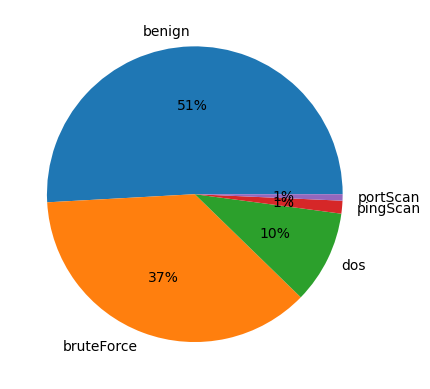

In [40]:
df_pred = pd.DataFrame([y_pred.numpy(), y_true.numpy()]).T
df_pred.columns = ['pred', 'true']
plt.pie(df_pred['true'][df_pred['pred'] != df_pred['true']].value_counts(), labels=labels, autopct='%.0f%%')

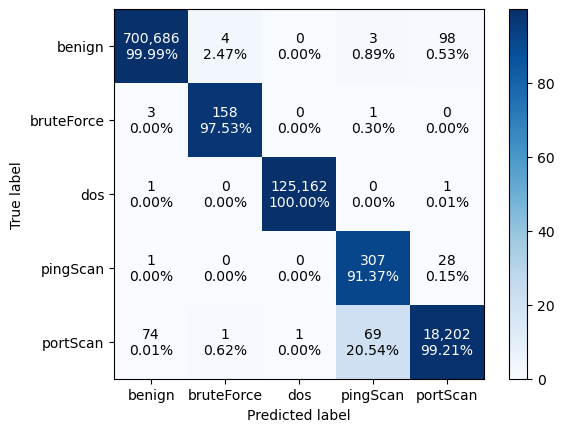

In [41]:
matrix = confusion_matrix(y_true, y_pred)
norm_matrix = matrix / matrix.sum(axis=1) * 100

plt.imshow(norm_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
    
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    text = f"{matrix[i,j]:,}\n{norm_matrix[i,j]:.2f}%"
    plt.text(j, i, text,
            horizontalalignment='center', verticalalignment='center',
            color='white' if matrix[i,j] >= matrix[i,:].mean() else 'black')
plt.show()